# Create map pickles in Cartopy

In [8]:
# import matplotlib
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap, cm
# import netCDF4 as nc
# import numpy as np
# import cmocean
# import pickle
# import cartopy.crs as ccrs
# import cartopy
# # import sys
# # sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
# import warnings
# warnings.filterwarnings('ignore')
# # import time
# # from matplotlib.patches import Polygon 
# # import matplotlib.image as mpimg
# # import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
import matplotlib
import matplotlib.pyplot as plt
import netCDF4 as nc
import cmocean
import numpy as np
import pickle

%matplotlib inline

In [2]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
lon   = np.array(mesh.variables['nav_lon'])
lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask = np.array(mesh.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1), tmask[0,:,:,:]) 

Parameters

In [3]:
land_color = '#a9a7a2'
land_edge  = '#373736'

Projections

In [4]:
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=20.0, pole_latitude=0)
flat_crs  = cartopy.crs.Miller(central_longitude=0)
npster    = cartopy.crs.NorthPolarStereo(central_longitude=-100)
plain_crs = cartopy.crs.PlateCarree()
globe_crs = ccrs.Orthographic(central_longitude=-60, central_latitude=20)

coastline_fine   = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor=land_edge, linewidth=0.25, facecolor=land_color)
coastline_coarse = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=land_edge, linewidth=0.5, facecolor=land_color)
waterline = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='none', linewidth=0.4, facecolor="#183C51")

In [22]:
def z_masked_overlap(axe, X, Y, Z, source_projection=None):
    """
    for data in projection axe.projection
    find and mask the overlaps (more 1/2 the axe.projection range)

    X, Y either the coordinates in axe.projection or longitudes latitudes
    Z the data
    operation one of 'pcorlor', 'pcolormesh', 'countour', 'countourf'

    if source_projection is a geodetic CRS data is in geodetic coordinates
    and should first be projected in axe.projection

    X, Y are 2D same dimension as Z for contour and contourf
    same dimension as Z or with an extra row and column for pcolor
    and pcolormesh

    return ptx, pty, Z
    """
    if not hasattr(axe, 'projection'):
        return Z
    if not isinstance(axe.projection, ccrs.Projection):
        return Z

    if len(X.shape) != 2 or len(Y.shape) != 2:
        return Z

    if (source_projection is not None and
            isinstance(source_projection, ccrs.Geodetic)):
        transformed_pts = axe.projection.transform_points(
            source_projection, X, Y)
        ptx, pty = transformed_pts[..., 0], transformed_pts[..., 1]
    else:
        ptx, pty = X, Y


    with np.errstate(invalid='ignore'):
        # diagonals have one less row and one less columns
        diagonal0_lengths = np.hypot(
            ptx[1:, 1:] - ptx[:-1, :-1],
            pty[1:, 1:] - pty[:-1, :-1]
        )
        diagonal1_lengths = np.hypot(
            ptx[1:, :-1] - ptx[:-1, 1:],
            pty[1:, :-1] - pty[:-1, 1:]
        )
        to_mask = (
            (diagonal0_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal0_lengths) |
            (diagonal1_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal1_lengths)
        )

        # TODO check if we need to do something about surrounding vertices

        # add one extra colum and row for contour and contourf
        if (to_mask.shape[0] == Z.shape[0] - 1 and
                to_mask.shape[1] == Z.shape[1] - 1):
            to_mask_extended = np.zeros(Z.shape, dtype=bool)
            to_mask_extended[:-1, :-1] = to_mask
            to_mask_extended[-1, :] = to_mask_extended[-2, :]
            to_mask_extended[:, -1] = to_mask_extended[:, -2]
            to_mask = to_mask_extended
        if np.any(to_mask):

            Z_mask = getattr(Z, 'mask', None)
            to_mask = to_mask if Z_mask is None else to_mask | Z_mask

            Z = ma.masked_where(to_mask, Z)

        return ptx, pty, Z

### Mn model surface map

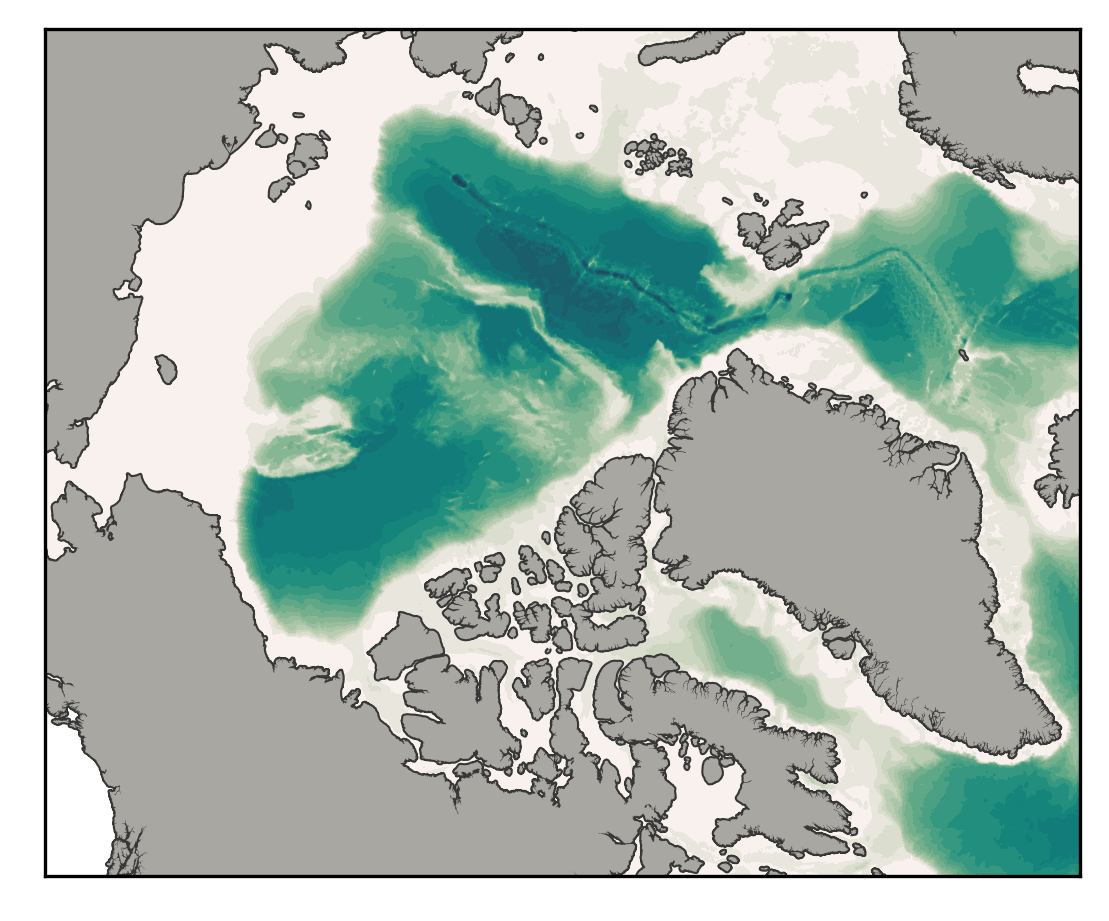

In [15]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1=Basemap(projection='stere',lat_0 = 84, lon_0 = -95, resolution='i', width=5.5e6, height=4.5e6, ax=ax1)

proj1.drawcoastlines(color='#373736', linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x_model, y_model = proj1(lon, lat)
bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000, zorder=1)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/AO-map.pickle','wb'))

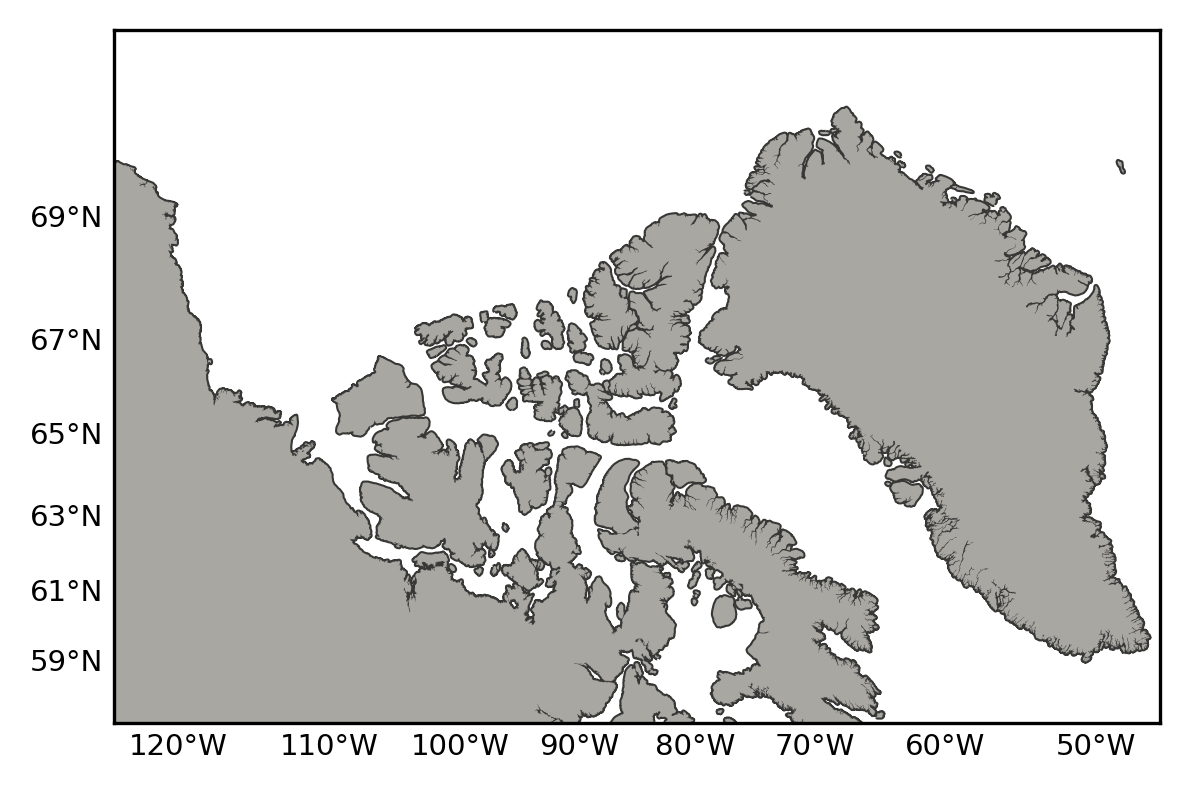

In [5]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=7)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=7)

land_color = '#a9a7a2'
proj1.drawcoastlines(color='#373736', linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

# x_model, y_model = proj1(lon, lat)
# bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000, zorder=1)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','wb'))

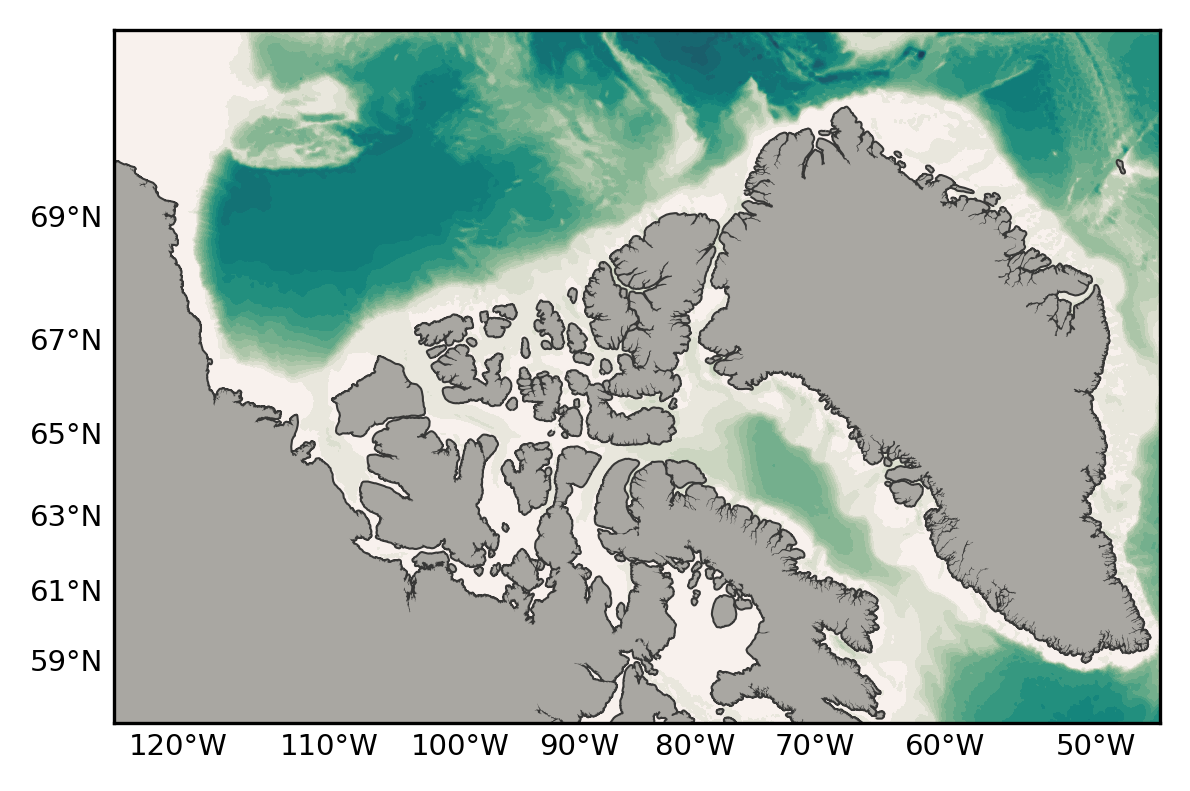

In [13]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=7)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=7)

land_color = '#a9a7a2'
proj1.drawcoastlines(color='#373736', linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x_model, y_model = proj1(lon, lat)
bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000, zorder=1)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/surface-land-map.pickle','wb'))

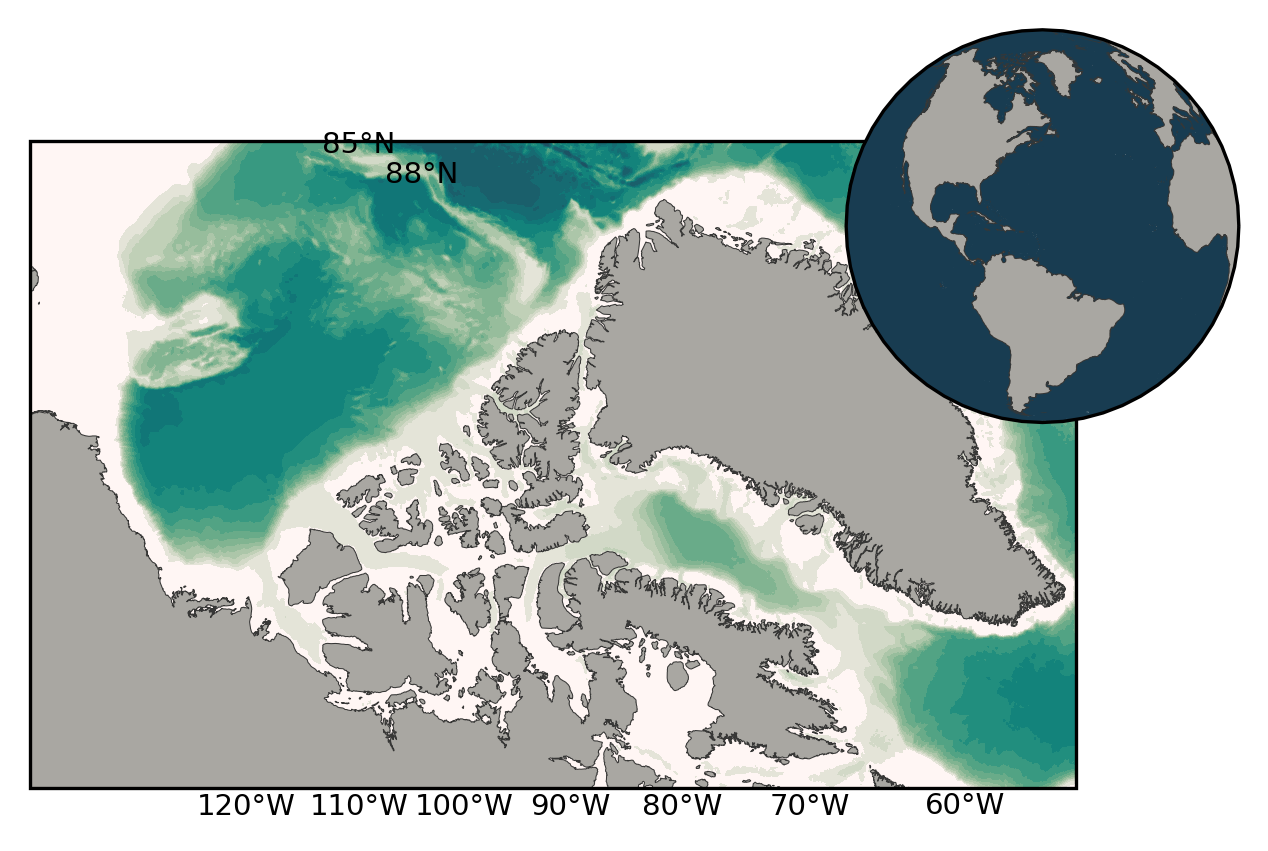

In [38]:
fig, ax = plt.subplots(figsize=(4.5, 3.74), dpi=300, subplot_kw={"projection": npster})

ax.add_feature(coastline_fine)
# ax.pcolormesh(lon, lat, mesh_bathy, transform=plain_crs, cmap=cmocean.cm.tempo, vmin=0, vmax=6000)
X, Y, mbathy_new = z_masked_overlap(ax, lon, lat, mesh_bathy, source_projection=ccrs.Geodetic())
contours_fill = plt.contourf(X, Y, mbathy_new, levels=20, extend="both", cmap=cmocean.cm.tempo, vmin=0, vmax=6000)
ax.set_extent([-145, -5, 75, 135], flat_crs)

gl = ax.gridlines(draw_labels=True, alpha=0)
gl.xlocator = mticker.FixedLocator(np.arange(-120,0,10))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {'size': 7, 'color': 'k','rotation':0}
gl.ylabel_style = {'size': 7, 'color': 'k','rotation':0}
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator(np.arange(70,90,1))
# gl.ylabels_left = False
gl.ylabels_right = False

ax2 = fig.add_axes([0.70, 0.54, 0.35, 0.35], projection=globe_crs)
ax2.add_feature(coastline_coarse)
ax2.add_feature(waterline)

# pickle the class instance.
# pickle.dump((fig, ax, ax2), open('/ocean/brogalla/GEOTRACES/pickles/cartopy/surface-land-map-globe.pickle','wb'))

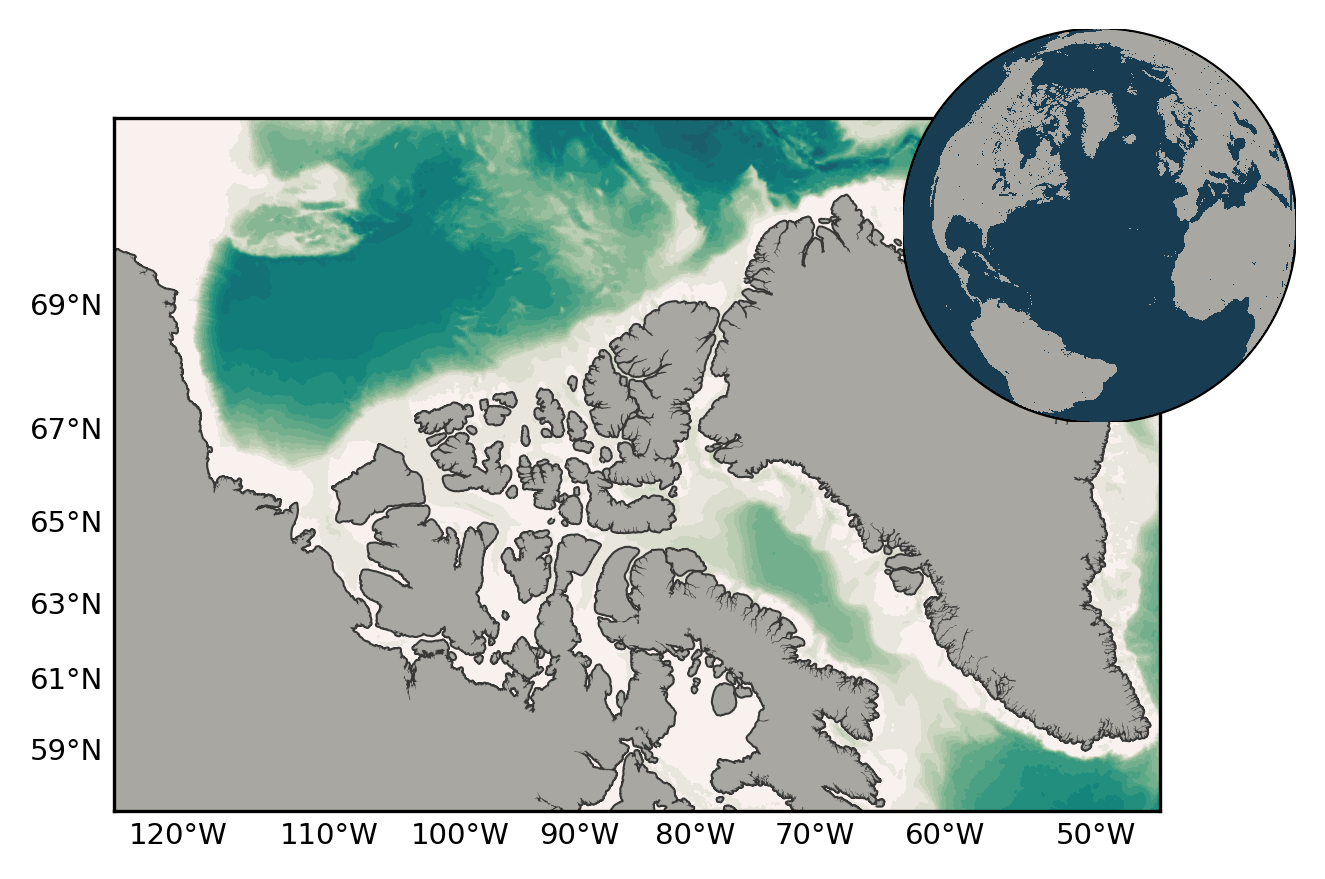

In [10]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=7)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=7)

proj1.drawcoastlines(color='#373736', linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x_model, y_model = proj1(lon, lat)
bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000, zorder=1)

ax2   = fig.add_axes([0.68, 0.54, 0.35, 0.35])
proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
proj2.drawmapboundary(fill_color='white')
proj2.drawlsmask(land_color = land_color, ocean_color="#183C51", resolution = 'h',zorder=2) 

# pickle the class instance.
pickle.dump((fig, ax1, proj1, ax2, proj2), open('/ocean/brogalla/GEOTRACES/pickles/cartopy_surface-land-map-globe.pickle','wb'))

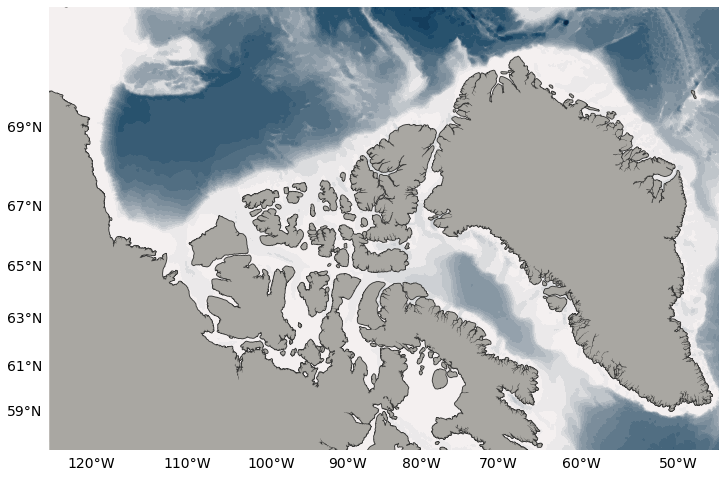

In [5]:
fig, ax1 = plt.subplots(figsize=(12,9))

# proj1=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -92, resolution='i', width=3.0e6, height=2.55e6, ax=ax1)
proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

land_color = '#a9a7a2'

x_model, y_model = proj1(lon, lat)
proj1.drawcoastlines(color='#373736', linewidth=1.8)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
# proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
# p = Polygon([(0, 0),(0, 400478),(1.427e6, 400478),(1.427e6, 0)], \
#             facecolor=land_color,edgecolor=land_color) 
# plt.gca().add_patch(p) 

bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.diff_r, vmin=-5000, vmax=5000, zorder=1)

# ax2   = fig.add_axes([0.68, 0.54, 0.35, 0.35])
# proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
# proj2.drawmapboundary(fill_color='white')
# proj2.drawlsmask(land_color = "#8b7765", ocean_color="#183C51", resolution = 'h',zorder=2) 

# nv = mpimg.imread('/ocean/brogalla/GEOTRACES/figures/nunavut.png')
# nwt = mpimg.imread('/ocean/brogalla/GEOTRACES/figures/NWT.png')

# ax3 = fig.add_axes([0.36, 0.16, 0.06, 0.04]) #nunavut
# ax3.axis('off')
# ax3.imshow(nv)
# ax4 = fig.add_axes([0.13, 0.29, 0.10, 0.04]) #northwest territories
# ax4.axis('off')
# ax4.imshow(nwt)

# # features:
# textx, texty = proj1(lon_features1, lat_features1)
# for i in range(len(features)):
#     if features[i] == 'Kalaallit Nunaat':
#         ax1.text(textx[i], texty[i], features[i], fontsize=16, fontweight='bold', color='w', zorder=4)
#     elif features[i] == 'Beaufort Sea':
#         ax1.text(textx[i], texty[i], features[i], fontsize=16, fontweight='bold', color='k', zorder=4)
#     else:
#         ax1.text(textx[i], texty[i], features[i], fontsize=16, fontweight='bold', fontstyle='italic', color='w',\
#                 zorder=4)

ax1.set_frame_on(False)
# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/surface-land-map2.pickle','wb'))

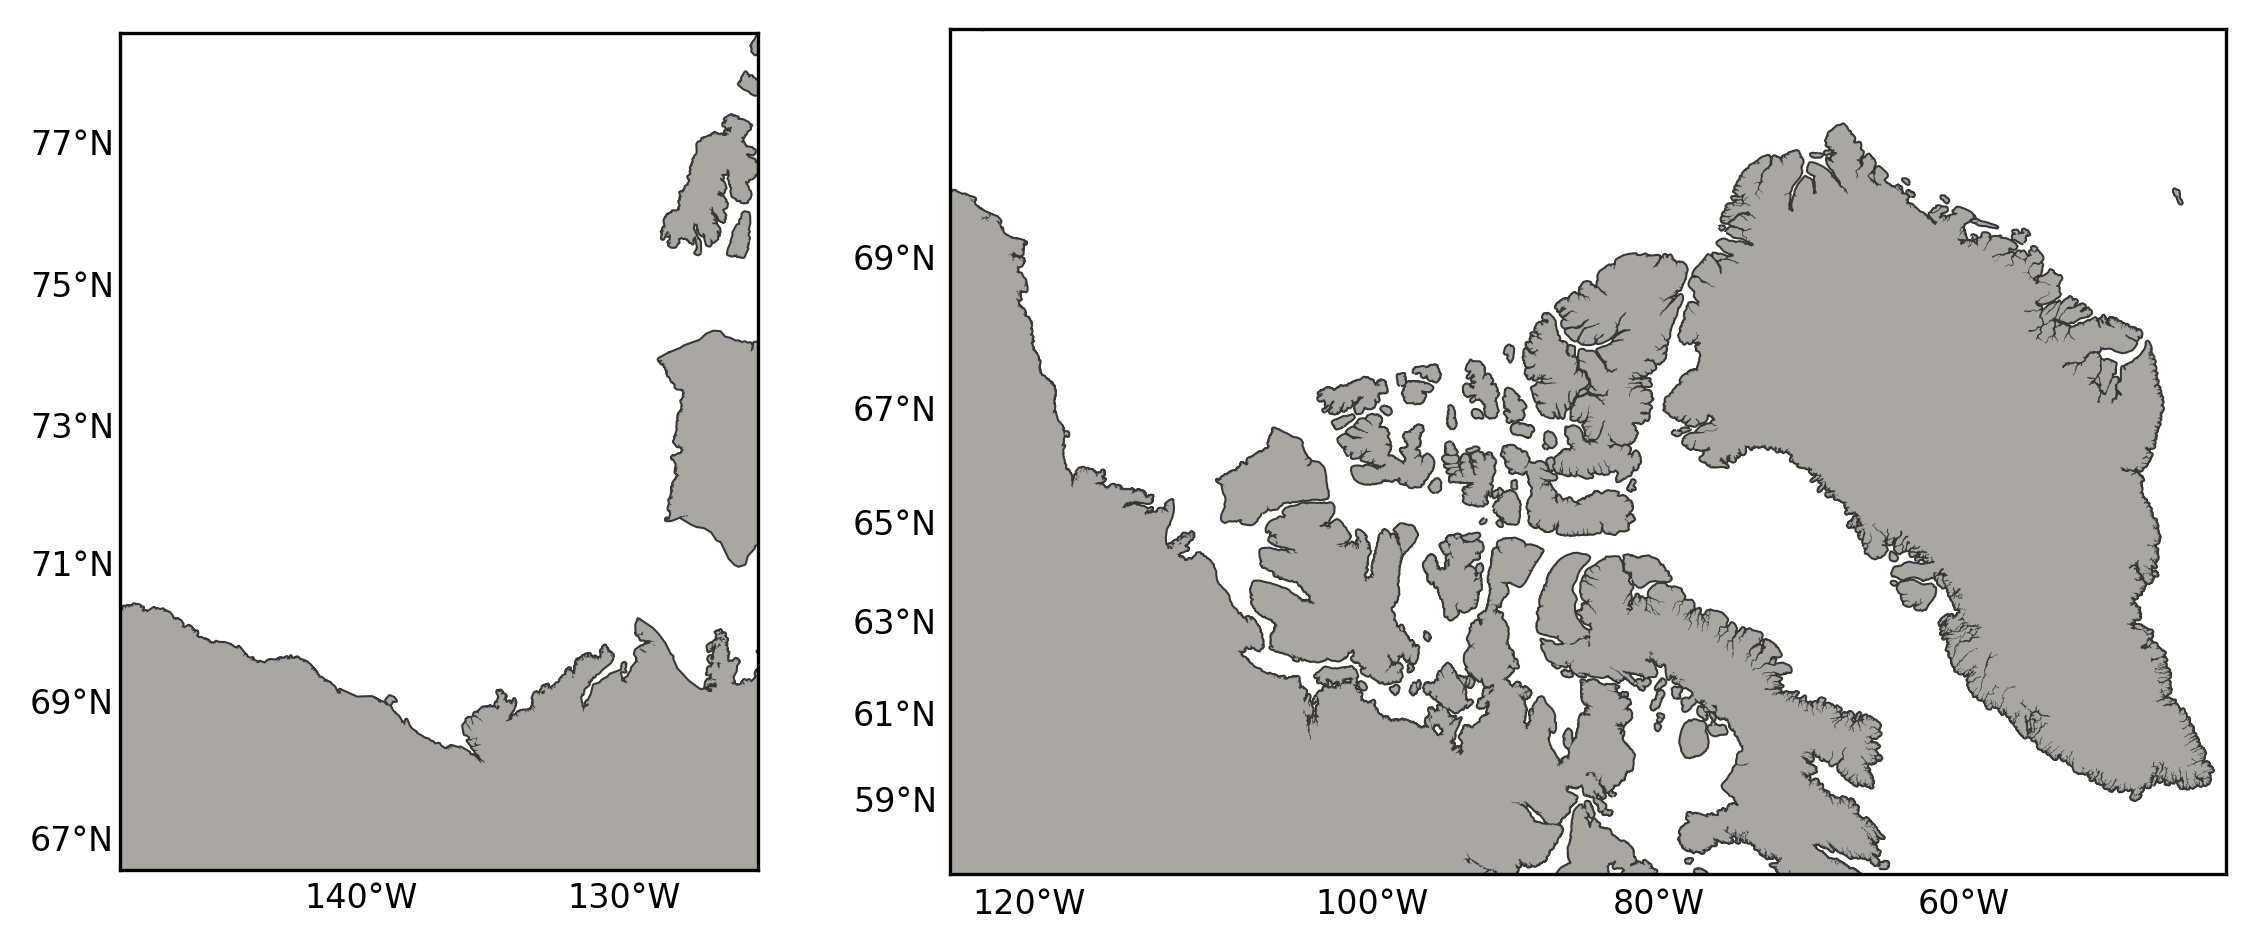

In [44]:
fig, ax1 = plt.subplots(1,2, figsize=(9.055, 3.74), dpi=300, gridspec_kw={'width_ratios': [1, 2]})

land_color = '#a9a7a2'

#--- Left plot ---
proj1 = Basemap(projection='stere',lat_0 = 73.3, lon_0 = -137, resolution='i', width=1.06e6, height=1.39e6, ax=ax1[0])
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=8)
proj1.drawmeridians(np.arange(int(-170),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=8)
proj1.drawcoastlines(color='#373736', linewidth=1.0)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

#--- Right plot ---
proj2 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1[1])
proj2.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=8)
proj2.drawmeridians(np.arange(int(-140),int(-30),20),labels=[0,0,0,1], linewidth=0.0, fontsize=8)
proj2.drawcoastlines(color='#373736', linewidth=1.0)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

# pickle the class instance.
pickle.dump((fig, ax1, proj1, proj2), open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','wb'))

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,10))

proj1 = Basemap(projection='stere',lat_0 = 78.2, lon_0 = -80, resolution='i', width=0.9e6, height=1.1e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

land_color = '#a9a7a2'

x_model, y_model = proj1(lon, lat)
proj1.drawcoastlines(color='#373736', linewidth=1.8)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

ax1.set_frame_on(False)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/nares-zoom.pickle','wb'))

<IPython.core.display.Javascript object>


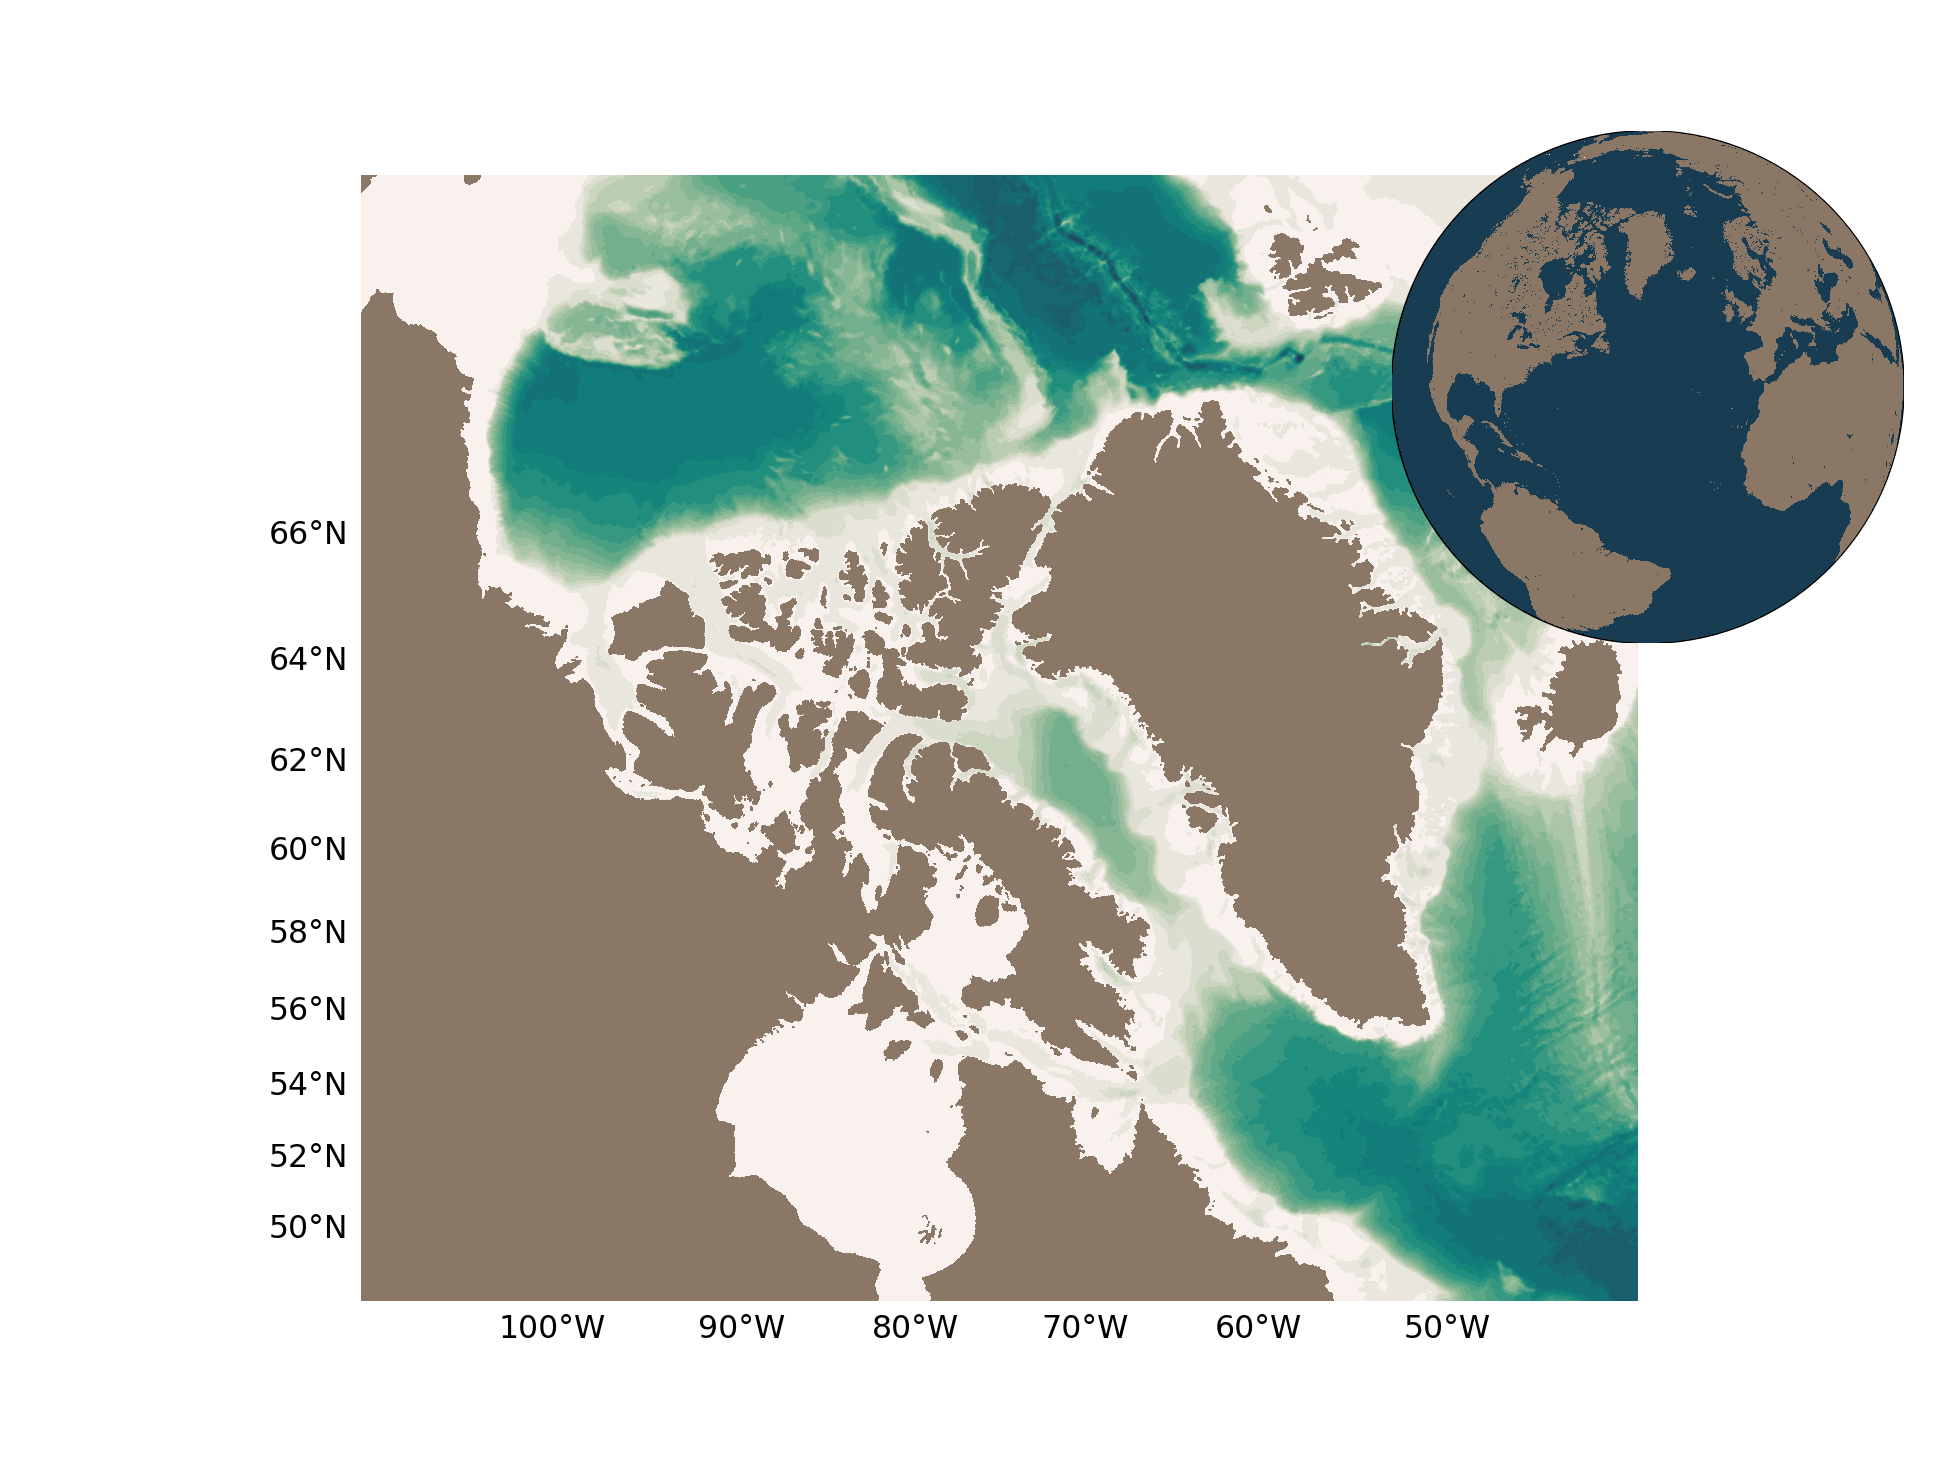

In [7]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1=Basemap(projection='stere',lat_0 = 74, lon_0 = -75, resolution='i', width=5.1e6, height=4.5e6, ax=ax1)
proj1.drawparallels(np.arange(int(50),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
p = Polygon([(0, 0),(0, 2.0e6),(1.3e6, 2.0e6),(1.3e6, 0)], \
            facecolor="#8b7765",edgecolor="#8b7765") 
plt.gca().add_patch(p) 

bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000, zorder=1)

ax2   = fig.add_axes([0.67, 0.56, 0.35, 0.35])
proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
proj2.drawmapboundary(fill_color='white')
proj2.drawlsmask(land_color = "#8b7765", ocean_color="#183C51", resolution = 'h',zorder=2) 

ax1.set_frame_on(False)
# pickle the class instance.
pickle.dump((fig, ax1, proj1, ax2, proj2), open('/ocean/brogalla/GEOTRACES/pickles/surface-Pb-map-globe.pickle','wb'))

<IPython.core.display.Javascript object>


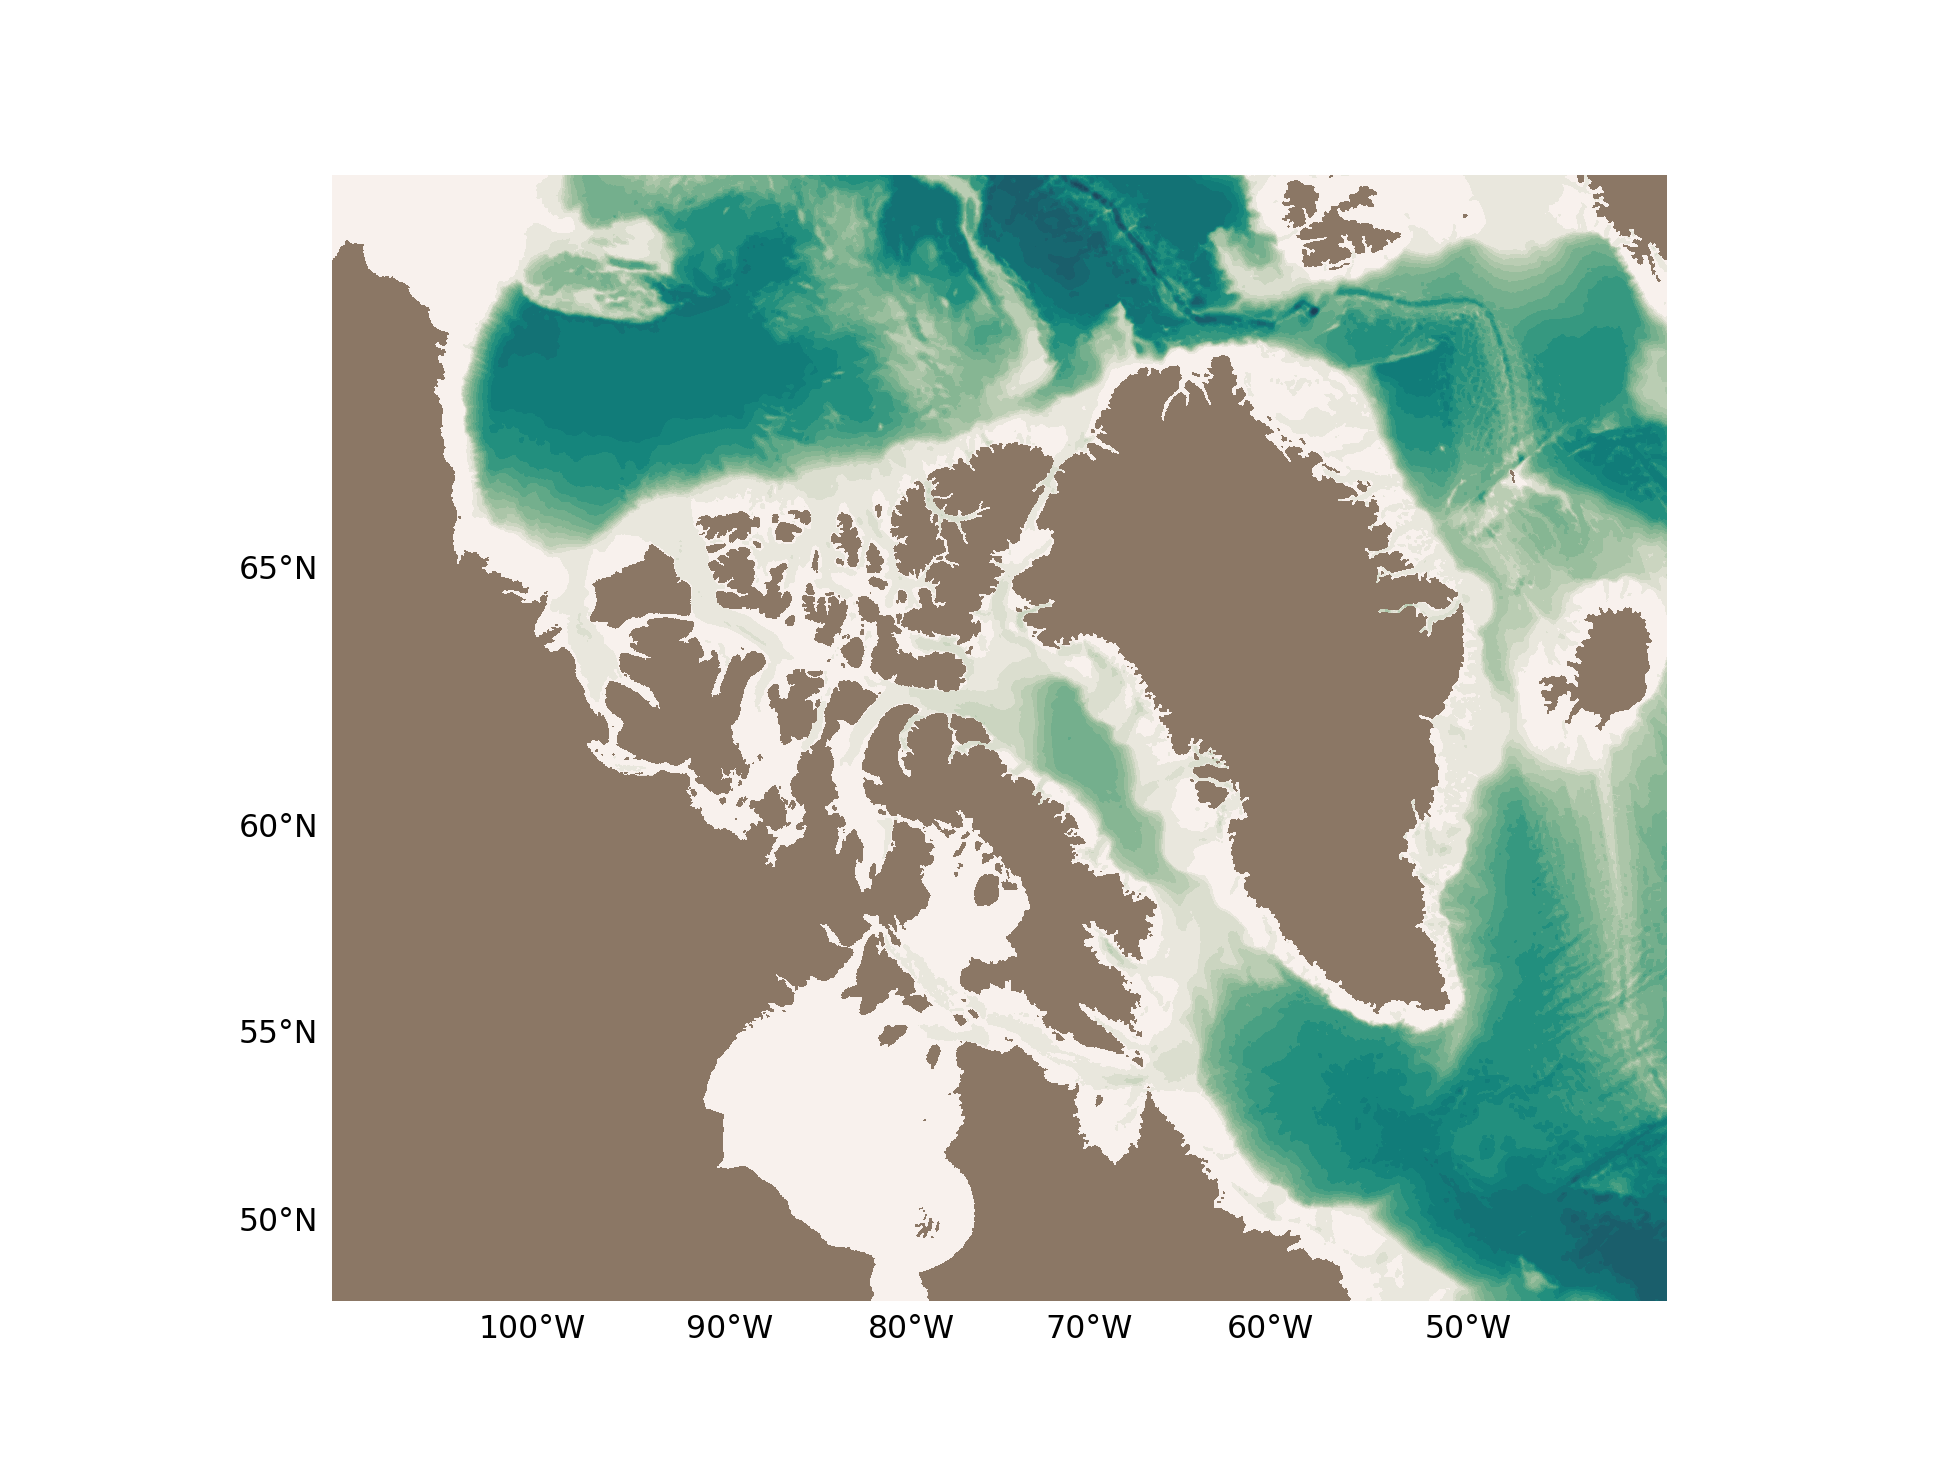

In [8]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1=Basemap(projection='stere',lat_0 = 73, lon_0 = -75, resolution='i', width=5.1e6, height=4.3e6, ax=ax1)
proj1.drawparallels(np.arange(int(50),int(90),5),labels=[1,0,0,0], linewidth=0.0, fontsize=14)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=14)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
p = Polygon([(0, 0),(0, 2.0e6),(1.3e6, 2.0e6),(1.3e6, 0)], \
            facecolor="#8b7765",edgecolor="#8b7765") 
plt.gca().add_patch(p) 

bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=6000, zorder=1)

# ax2   = fig.add_axes([0.67, 0.56, 0.35, 0.35])
# proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
# proj2.drawmapboundary(fill_color='white')
# proj2.drawlsmask(land_color = "#8b7765", ocean_color="#183C51", resolution = 'h',zorder=2) 

ax1.set_frame_on(False)
# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/surface-Pb-map.pickle','wb'))

Mn reference:

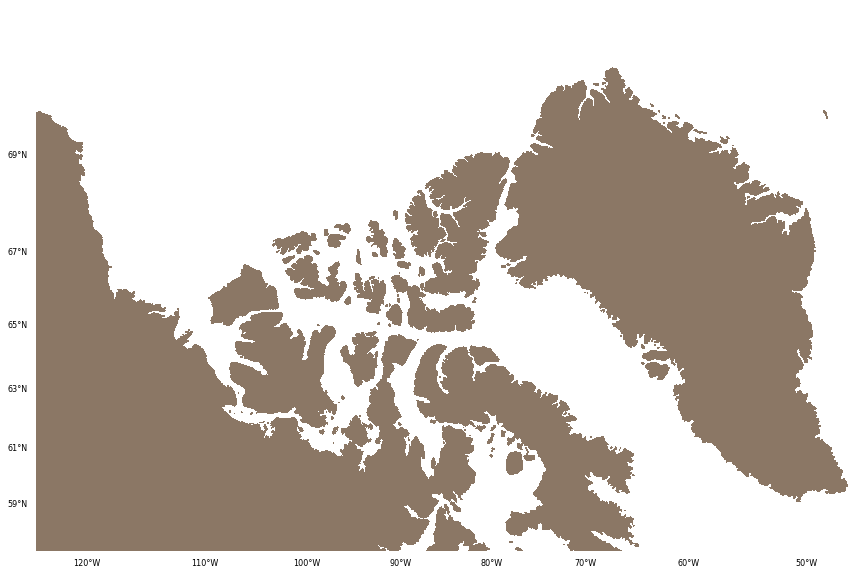

In [5]:
fig, ax1 = plt.subplots(figsize=(16,10))

proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=8)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=8)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
p = Polygon([(0, 0),(0, 400478),(1.427e6, 400478),(1.427e6, 0)], \
            facecolor="#8b7765",edgecolor="#8b7765") 
plt.gca().add_patch(p) 

ax1.set_frame_on(False)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','wb'))

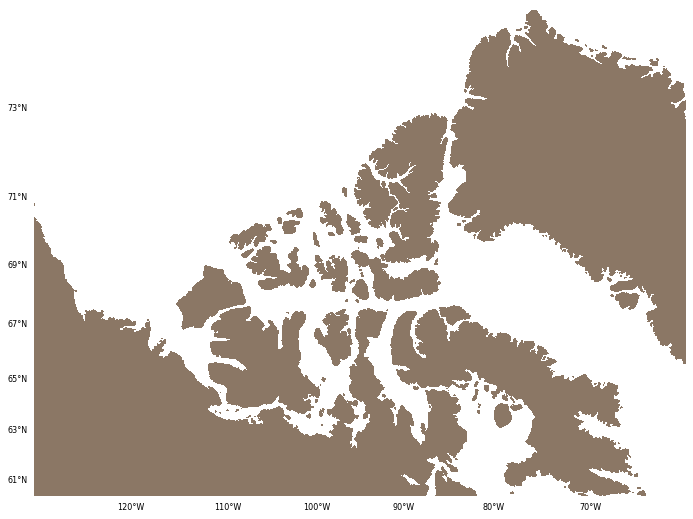

In [7]:
fig, ax1 = plt.subplots(figsize=(12,9))

proj1 = Basemap(projection='stere',lat_0 = 77.0, lon_0 = -95, resolution='i', width=3.6e6, height=2.7e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=8)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=8)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
p = Polygon([(0, 0),(0, 400478),(1.427e6, 400478),(1.427e6, 0)], \
            facecolor="#8b7765",edgecolor="#8b7765") 
plt.gca().add_patch(p) 

ax1.set_frame_on(False)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/mn-zoom.pickle','wb'))

<IPython.core.display.Javascript object>


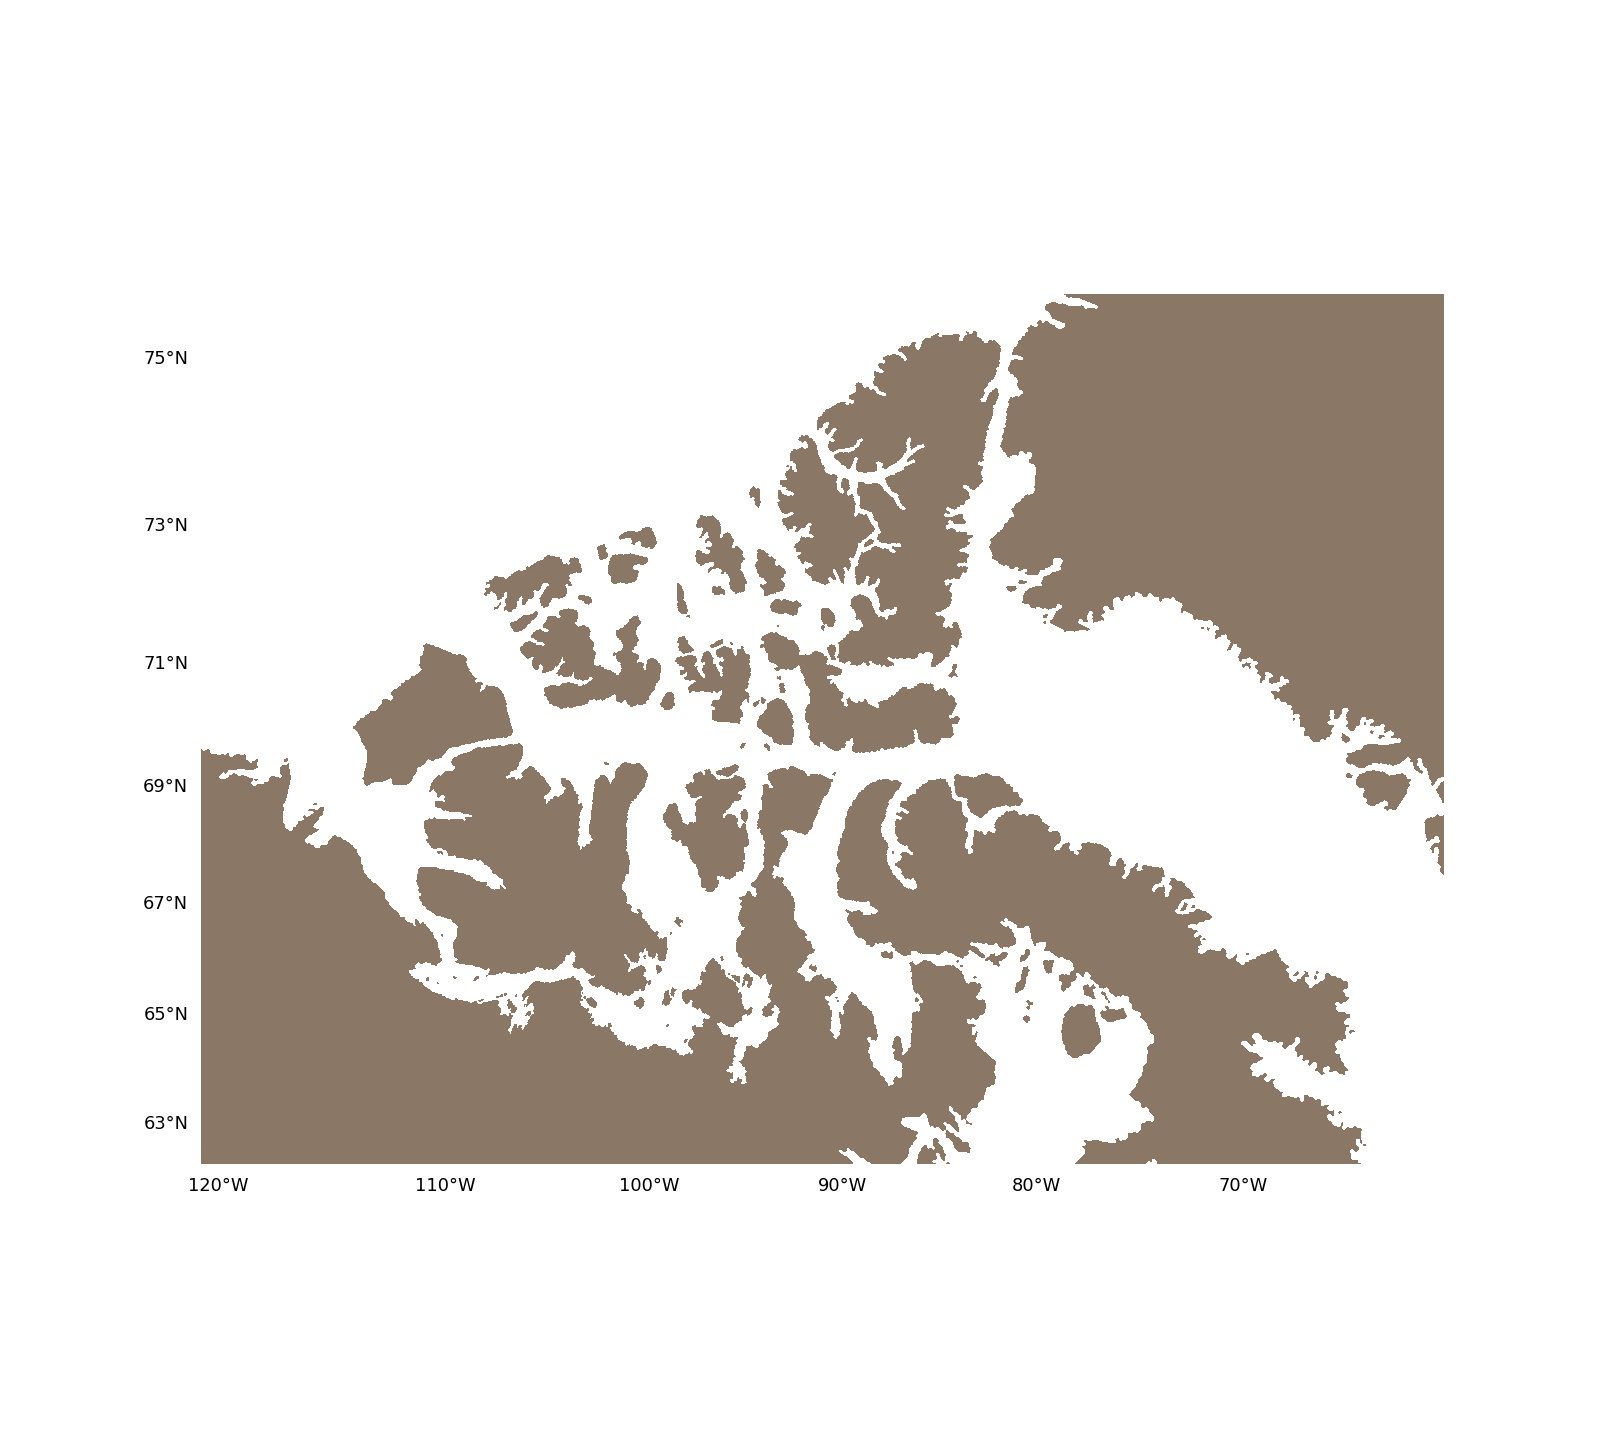

In [7]:
fig, ax1 = plt.subplots(figsize=(10,9))

proj1 = Basemap(projection='stere',lat_0 = 75, lon_0 = -91, resolution='i', width=3.0e6, height=2.1e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=8)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=8)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
p = Polygon([(0, 0),(0, 0.3e6),(1e6, 0.3e6),(1e6, 0)], \
            facecolor="#8b7765",edgecolor="#8b7765") 
plt.gca().add_patch(p) 

ax1.set_frame_on(False)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/caa.pickle','wb'))

<IPython.core.display.Javascript object>


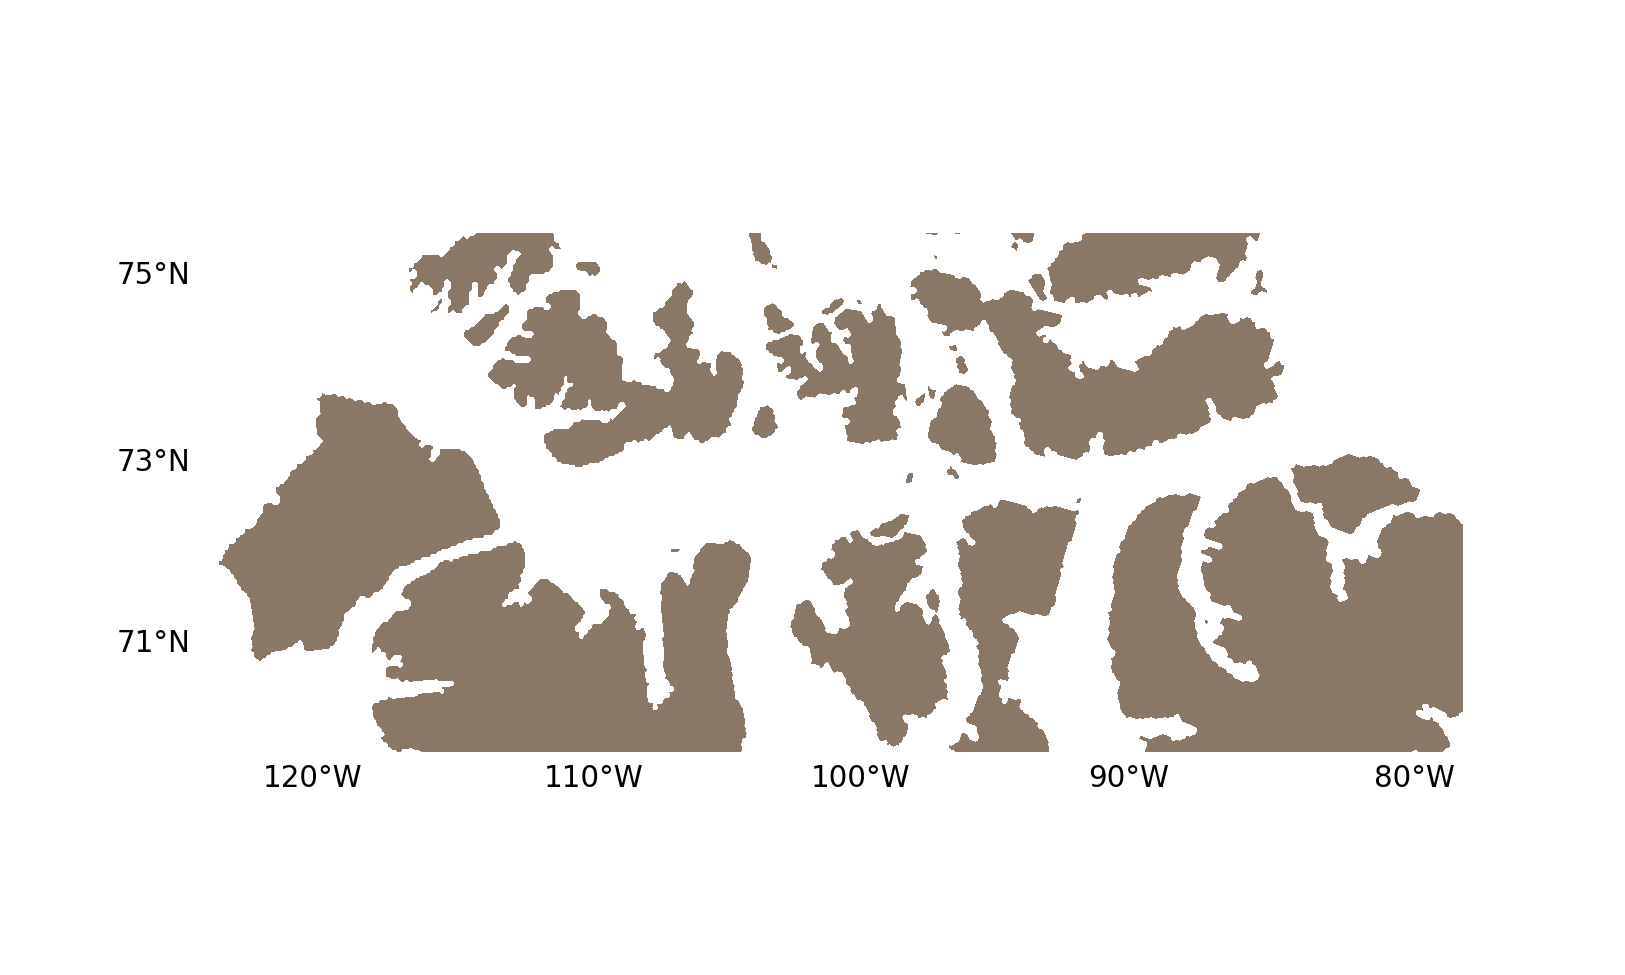

In [24]:
fig, ax1 = plt.subplots(figsize=(10,6))

proj1 = Basemap(projection='stere',lat_0 = 74.4, lon_0 = -101, resolution='h', width=1.7e6, height=0.7e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=13)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=13)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)

ax1.set_frame_on(False)

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/parry-channel.pickle','wb'))

Pb extended surface pickle:

<IPython.core.display.Javascript object>


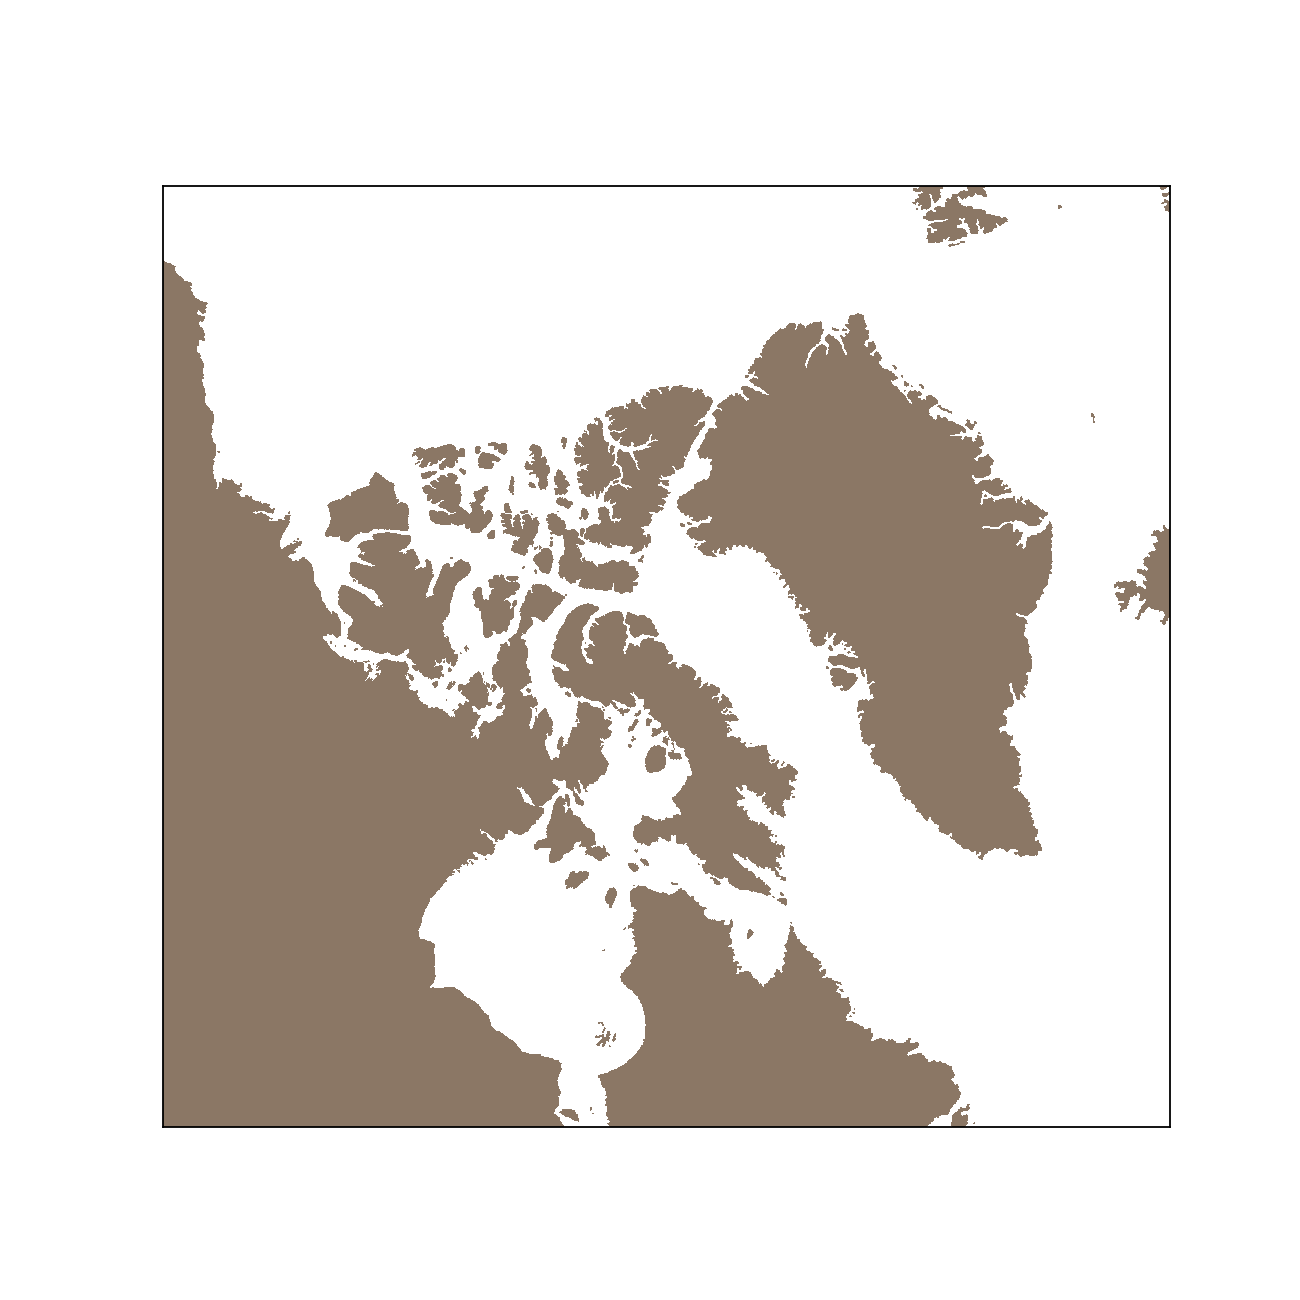

In [6]:
fig, ax1 = plt.subplots(figsize=(8,8))

proj1=Basemap(projection='eqdc',lat_0 = 72, lon_0 = -75, resolution='i', width=4.6e6, height=4.3e6, ax=ax1)

x_model, y_model = proj1(lon, lat)
proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=1)

p = Polygon([(0,1.836e6),(986670, 1.885e6),(980955, 0),(0, 0)], \
            facecolor="#8b7765",edgecolor="#8b7765") 
plt.gca().add_patch(p) 

# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/surface-Pb.pickle','wb'),-1)

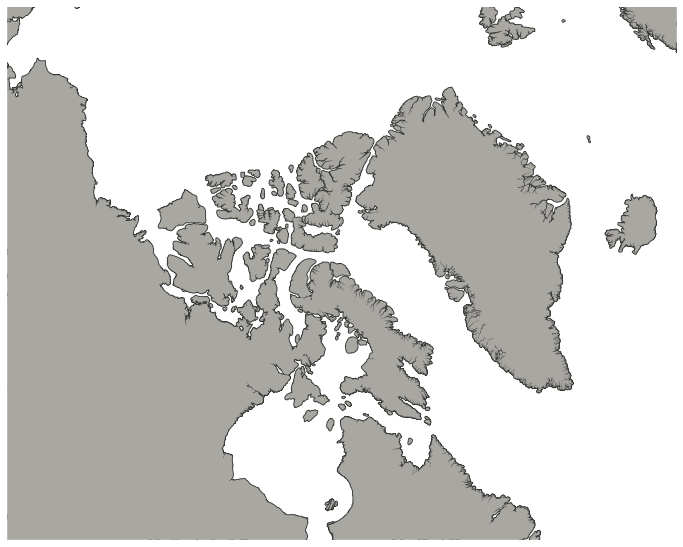

In [8]:
fig, ax1 = plt.subplots(figsize=(12,10))

land_color = '#a9a7a2'
proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj1.drawcoastlines(color='#373736', linewidth=1.8);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

ax1.set_frame_on(False)
# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','wb'))

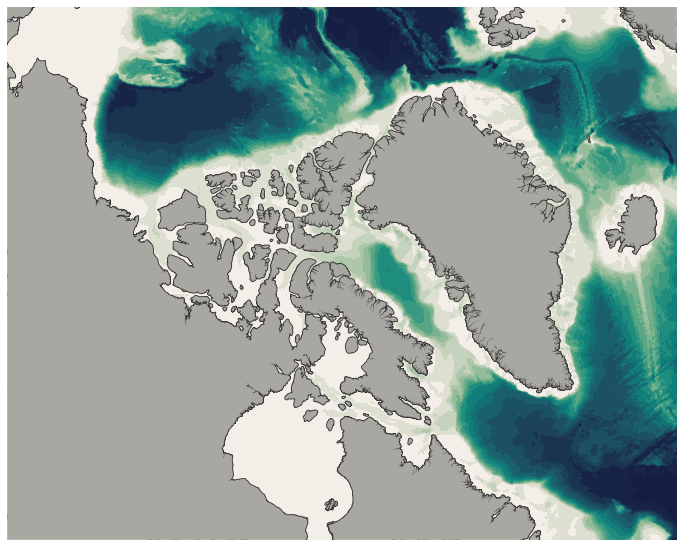

In [9]:
fig, ax1 = plt.subplots(figsize=(12,10))

land_color = '#a9a7a2'
proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj1.drawcoastlines(color='#373736', linewidth=1.8);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

x_model, y_model = proj1(lon, lat)
# proj1.contourf(x_model, y_model, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=2)
# p = Polygon([(0, 0),(0, 2.0e6),(1.3e6, 2.0e6),(1.3e6, 0)], \
#             facecolor="#8b7765",edgecolor="#8b7765") 
# plt.gca().add_patch(p) 
bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=cmocean.cm.tempo, vmin=0, vmax=4000, zorder=1)

ax1.set_frame_on(False)
# pickle the class instance.
pickle.dump((fig, ax1, proj1), open('/ocean/brogalla/GEOTRACES/pickles/pb-bathy.pickle','wb'))

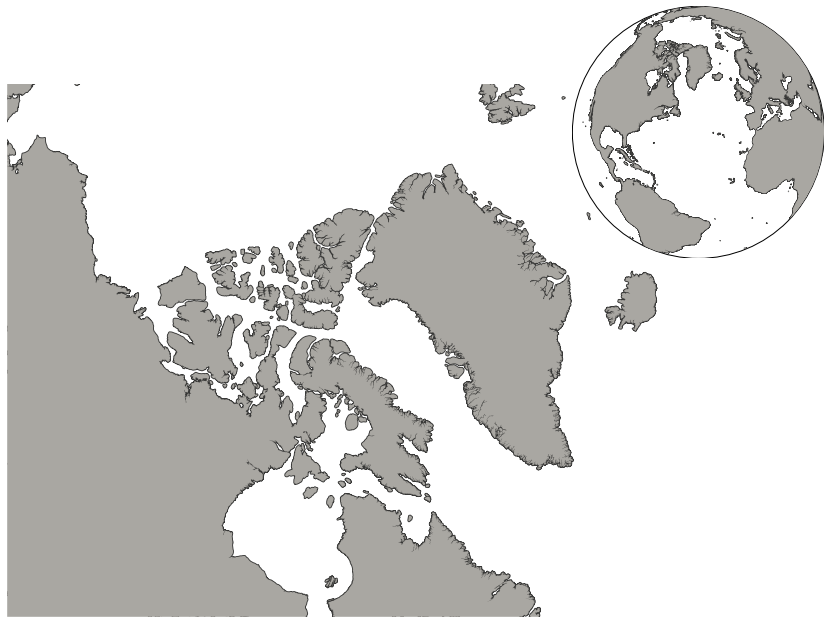

In [9]:
fig, ax1 = plt.subplots(figsize=(12,10))

land_color = '#a9a7a2'
proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
proj1.drawcoastlines(color='#373736', linewidth=1.8);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

ax1.set_frame_on(False)

ax2   = fig.add_axes([0.75, 0.63, 0.35, 0.35])
proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
proj2.drawcoastlines(color='#373736', linewidth=1.3);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

# pickle the class instance.
pickle.dump((fig, ax1, proj1, ax2, proj2), open('/ocean/brogalla/GEOTRACES/pickles/pb-surface-globe.pickle','wb'))